In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import keras
import librosa
import os
import re
from tqdm import tqdm
import tensorflow as tf
import warnings
from tqdm import tqdm


### Use cuda acceleration (optional)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
path = './AUDIO_DATA'

### Link your google drive storage if you are working on google colab (optional)  

In [3]:
path = '<your google drive path>'
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/DurianAudios

# **1. Data and features extraction : MFCC**
---

 Firstly, we are going to prepare our data using MFCC, a method which allow us to extract the features of an audio.

In [8]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="PySoundFile failed.*")

audiosdir = path

audios_75_85 = []
audios_95 = []

def tri_audio(audio_name):
  if(audio_name not in [*audios_75_85,*audios_95]):
    try:
      if(re.split('_|%',audio_name)[3] == "75-85"):
        audios_75_85.append(audio_name)
      else:
        audios_95.append(audio_name)
    except :
      print(audio_name)
for i in sorted(os.listdir(audiosdir)):
  tri_audio(i)


In [9]:
def load_audio(file_name, audio_path=audiosdir):
    full_path = os.path.join(audio_path, file_name)
    y, sr = librosa.load(full_path, sr=None)
    return y, sr

In [10]:
loaded_good = [load_audio(f) for f in tqdm(audios_75_85)]
loaded_bad = [load_audio(f) for f in tqdm(audios_95)]

100%|██████████| 47/47 [00:03<00:00, 14.29it/s]


### Then we compute the MFCC coefficients

In [11]:
n_mfcc     = 40        # number of coefficients
n_fft      = 2048      # window size STFT
hop_length = 512

def compute_mfcc(lst: list):
  for fn in lst:
      y, sr = load_audio(fn)
      mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
      yield librosa.util.normalize(mfcc_features, axis=1)

mfcc_list = [*compute_mfcc(audios_75_85), *compute_mfcc(audios_95)]

# **2. Audio dataset preparation (padding and trimming)**

Besides, the idea is to set a single length T_max (typically the maximum recorded value) and then, for each MFCC:  
*   If T_i < T_max → pad with columns of trailing zeros
*   If T_i > T_max → trim to keep only the first T_max frames  

In [12]:
T = list(mfcc.shape[1] for mfcc in mfcc_list)
print(*T)
T_max = max(T)
print(f'The maximum value of time is {T_max} ms')

244 244 250 257 257 268 268 273 271 248 246 241 273 244 239 266 248 271 262 244 244 268 246 248 246 271 246 271 273 255 266 268 271 246 259 246 266 266 268 246 246 248 268 248 248 241 244 268 248 268 246 262 271 268 271 268 248 255 264 255 264 244 246 259 255 248 246 259 273 262 221 201 250 244 268 246 271 268 271 255 262 271 255 246 268 246 273 250 257 268 248 244
The maximum value of time is 273 ms


In this step, we ensure that all MFCCs have the same length by either padding them with zeros or trimming them to a fixed length, `T_max`. This is necessary to standardize the input size for the model.

In [14]:
mfcc_fixed = []
for m in mfcc_list:
    T_i = m.shape[1]
    if T_i < T_max:
        # padding
        pad_width = T_max - T_i
        m2 = np.pad(m,
                    pad_width=((0,0),   # no padding on coefficient axis
                    (0,pad_width)),     # padding to the right for time axis
                    mode='constant',
                    constant_values=0)
    else:
        # trimming
        m2 = m[:, :T_max]
    mfcc_fixed.append(m2)

# **3. Dataset formatting for model input**
---
At this stage, we will prepare our padded/truncated MFCCs into the right shape for our deep learning model (flattening, stacking, or reshaping as needed), and associate them with their corresponding labels.


In [15]:
X = np.stack(mfcc_fixed, axis=0)

X = X[..., np.newaxis]

print("X.shape =", X.shape)

X.shape = (92, 40, 273, 1)


In [16]:
y = np.array([1]*len(audios_75_85) + [0]*len(audios_95))
print("y.shape =", y.shape)

y.shape = (92,)


# **4. Train/Test split**
---
To evaluate our model fairly, we split the dataset into a training set and a test set. Usually, we use a ratio like 80/20.


In [17]:
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

In [18]:
separation = int(len(X)*(80/100))

x_train = X[:separation]
y_train = y[:separation]
x_test = X[separation:]
y_test = y[separation:]

Shuffle training data ton ensure linear accuracy progress during training

In [19]:
indices = np.arange(len(x_train))
np.random.shuffle(indices)
y_train = y_train[indices]
x_train = x_train[indices]

# **5. Building the classification model**
---
Now let's define our deep learning model. We'll use a simple Convolutional Neural Network (CNN) architecture suitable for audio classification.


In [21]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Input, BatchNormalization, Dropout, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical


In [39]:
model = Sequential([
    Input(shape=x_train.shape[1:]),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [31]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [40]:
def compile_model(model, learning_rate: int | None = None):
    if learning_rate is not None:
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return opt
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [41]:
compile_model(model)

# **6. Model training**
---
Let's train the model on the training data and keep track of its performance.


In [42]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=60,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es],
    shuffle=True,
)

Epoch 1/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - accuracy: 0.5219 - loss: 18.2840 - val_accuracy: 0.3333 - val_loss: 1.5848
Epoch 2/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5679 - loss: 10.7425 - val_accuracy: 0.6667 - val_loss: 0.7387
Epoch 3/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5449 - loss: 13.6791 - val_accuracy: 0.6667 - val_loss: 0.6743
Epoch 4/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6774 - loss: 4.4553 - val_accuracy: 0.3333 - val_loss: 1.3214
Epoch 5/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.5366 - loss: 7.2328 - val_accuracy: 0.3333 - val_loss: 1.2075
Epoch 6/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6024 - loss: 5.9352 - val_accuracy: 0.3333 - val_loss: 0.7813
Epoch 7/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7881 - loss: 2.6881 - val_accuracy: 0.7333 - val_loss: 0.6181
Epoch 8/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7996 - loss: 2.3248 - val_accuracy: 0.8000 - val_lo

# **7. Model evaluation**
---
We now evaluate the trained model on the test set, check the accuracy, and display a confusion matrix for detailed analysis.


In [43]:
loss, acc = model.evaluate(x_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6316 - loss: 0.6776


# **8. Results & analysis**
---
Let's analyze the results, discuss strengths and weaknesses, and try to interpret what the model is learning.


In [36]:
print("y_train repartition :", np.bincount(y_train))
print("y_test repartition :", np.bincount(y_test))

y_train repartition : [40 33]
y_test repartition : [ 7 12]


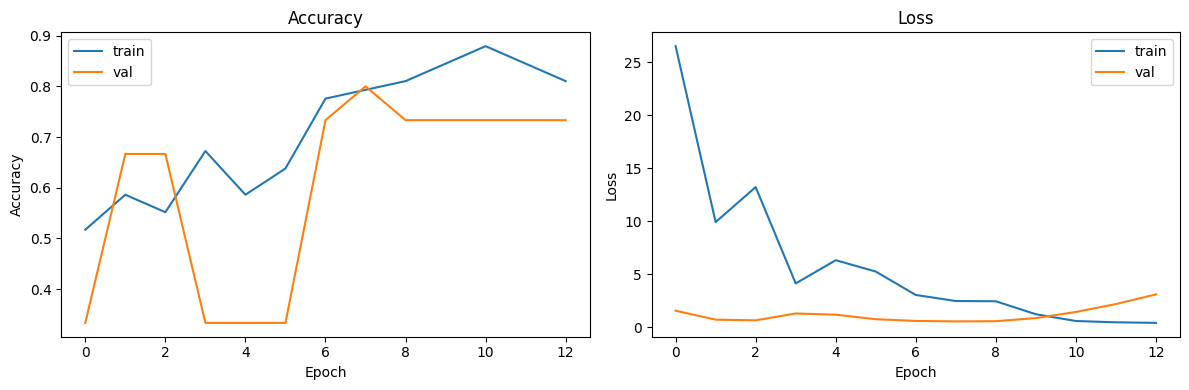

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


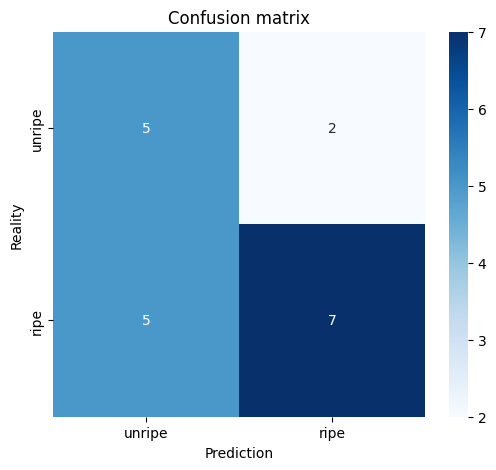

              precision    recall  f1-score   support

      unripe       0.50      0.71      0.59         7
        ripe       0.78      0.58      0.67        12

    accuracy                           0.63        19
   macro avg       0.64      0.65      0.63        19
weighted avg       0.68      0.63      0.64        19

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [44]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Confusion matrix
y_prob = model.predict(x_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ['unripe', 'ripe']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Prediction")
plt.ylabel("Reality")
plt.title("Confusion matrix")
plt.show()

print(classification_report(y_test, y_pred, target_names=labels))

keras.utils.plot_model(model, show_shapes=True)

# **9. Save model**
---
Finally, we save our trained model for later use, and discuss possible improvements or future work.


In [ ]:
# only execute the first time 
model_version_index = 1

In [ ]:
model.save(f"models/model_v{model_version_index}_({loss:.2f}, {acc:.2f})_.keras")
model_version_index+=1